In [134]:
import pandas as pd
import random

import os
# Keep using Keras 2
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import numpy as np
import matplotlib

In [2]:
df = pd.read_csv('answerList_data.csv')

def calculate_ttr(text):
    words = str(text).split()
    unique = set(words)
    ttr = len(unique) / len(words)
    return ttr

df['complexity'] = df['Answer.explanation'].apply(calculate_ttr)

In [8]:
bug_reports = df['FailingMethod'].unique()
random.shuffle(bug_reports)
# holdout_methods = bug_reports[0:2]
holdout_methods = ['HIT01_8', 'HIT03_6']

In [9]:
holdout_df = df[df['FailingMethod'].isin(holdout_methods)]
train_df = df[~ df['FailingMethod'].isin(holdout_methods)]

In [10]:
print(holdout_df['FailingMethod'].unique())
print(train_df['FailingMethod'].unique())

['HIT01_8' 'HIT03_6']
['HIT02_24' 'HIT04_7' 'HIT05_35' 'HIT06_51' 'HIT07_33' 'HIT08_54']


In [12]:
holdout_df = holdout_df.drop(columns=['TP', 'TN', 'FN', 'FP'])
train_df = train_df.drop(columns=['TP', 'TN', 'FN', 'FP'])

In [15]:
import tensorflow_decision_forests as tfdf

In [49]:
label = "GroundTruth"

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
holdout_ds = tfdf.keras.pd_dataframe_to_tf_dataset(holdout_df, label=label)
complete_ds = tfdf.keras.pd_dataframe_to_tf_dataset(df, label=label)

In [51]:
tuner = tfdf.tuner.RandomSearch(num_trials=5, use_predefined_hps=True)
model_1 = tfdf.keras.RandomForestModel(tuner=tuner)


model_1.fit(train_ds, verbose=2)

Use /var/folders/36/2qtcl0jx6r94h6345h20r6880000gn/T/tmppodepudc as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'Answer.ID': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'FailingMethod': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'Question.ID': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'Answer.duration': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'Answer.confidence': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'Answer.difficulty': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'Answer.option': <tf.Tensor 'data_6:0' shape=(None,) dtype=string>, 'Answer.order': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'Answer.explanation': <tf.Tensor 'data_8:0' shape=(None,) dtype=string>, 'Code.LOC': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'Code.complexity': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'Worker.ID': <tf.Tensor 'data_11:0' shape=(None,) dtype=string>, 'Worker.score': <tf.Tensor 

Training dataset read in 0:00:00.340006. Found 2040 examples.
Training model...
Model trained in 0:02:44.667931
Compiling model...
Model compiled.


In [129]:
model_1.summary()

Model: "random_forest_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (21):
	Answer.ID
	Answer.confidence
	Answer.difficulty
	Answer.duration
	Answer.explanation
	Answer.option
	Answer.order
	Code.LOC
	Code.complexity
	FailingMethod
	Question.ID
	Worker.ID
	Worker.age
	Worker.country
	Worker.gender
	Worker.profession
	Worker.programmingLanguage
	Worker.score
	Worker.whereLearnedToCode
	Worker.yearsOfExperience
	complexity

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.                  "Answer.ID"  0.559663 ################
    2.               "Answer.order"  0.229495 ###
    3.                   "Code.LOC"  0.165402 #
    4.            "Answer.du

In [52]:
model_1.compile(metrics=['Precision', 'Recall'])
evaluation = model_1.evaluate(holdout_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 414ms/step - loss: 0.0000e+00 - precision: 0.1829 - recall: 0.2500

loss: 0.0000
precision: 0.1829
recall: 0.2500


In [54]:
predictions = model_1.predict(complete_ds, verbose=2)
predictions

3/3 - 0s - 285ms/epoch - 95ms/step


array([[0.07666666],
       [0.07333333],
       [0.08333332],
       ...,
       [0.        ],
       [0.00666667],
       [0.09666664]], dtype=float32)

In [55]:
df['Prediction'] = predictions
df['PredictionRounded'] = predictions
df.PredictionRounded = df.PredictionRounded.round()
df['RightPrediction'] = np.where(df['PredictionRounded'] == df['GroundTruth'], True, False)
df['ExplanationLength'] = df['Answer.explanation'].str.len()

bug_df = df[df['GroundTruth'] == 1]
holdout_bug_df = df[df['FailingMethod'].isin(holdout_methods)]
holdout_bug_df

,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,TP,TN,FN,...,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,complexity,Prediction,PredictionRounded,RightPrediction,ExplanationLength
0,261,HIT01_8,0,90.984,4,2,0,0,1,0,...,21,Male,High School,United States,Java; C++; C#,0.937500,0.076667,0.0,True,98.0
1,262,HIT01_8,0,133.711,5,1,0,0,1,0,...,25,Female,High School;University;Web,United States,c#,0.923077,0.073333,0.0,True,67.0
2,263,HIT01_8,0,77.696,5,2,0,0,1,0,...,24,Male,High School;University;Web,United States,C++;Java;PHP,0.827586,0.083333,0.0,True,163.0
3,264,HIT01_8,0,46.644,1,1,0,0,1,0,...,38,Male,High School;University;Other On the job,USA,C#,1.000000,0.076667,0.0,True,64.0
4,265,HIT01_8,0,215.416,5,5,0,0,1,0,...,19,Male,High School;University;Web,United States,C++; Java,0.941176,0.066667,0.0,True,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,596,HIT03_6,32,192.740,0,5,1,0,0,1,...,53,Male,University,US,perl; c; javascript; php,1.000000,0.273333,0.0,False,126.0
656,597,HIT03_6,32,324.765,3,3,1,1,0,0,...,18,Male,High School;University,United States of America,Java,1.000000,0.223333,0.0,False,70.0
657,598,HIT03_6,32,2438.034,3,5,1,1,0,0,...,31,Male,High School;Web,United States of America,C#,0.656250,0.243333,0.0,False,711.0
658,599,HIT03_6,32,478.805,2,5,1,1,0,0,...,33,Male,High School;University,USA,C#,0.913043,0.540000,1.0,True,236.0


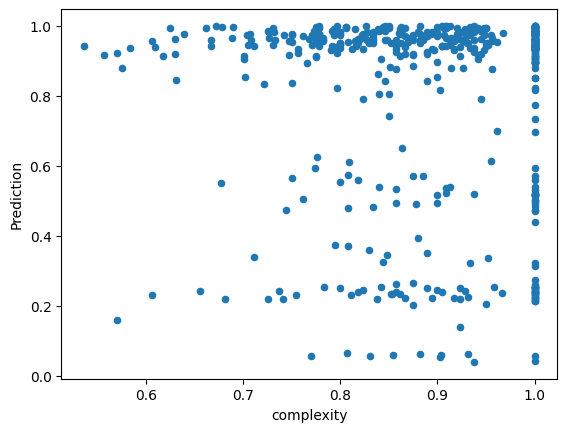

In [125]:
plot_1 = bug_df.plot(kind='scatter', x='complexity', y='Prediction')

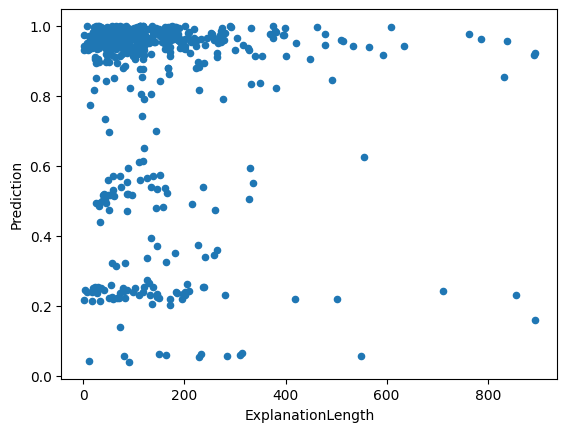

In [126]:
plot_2 = bug_df.plot(kind='scatter', x='ExplanationLength', y='Prediction')

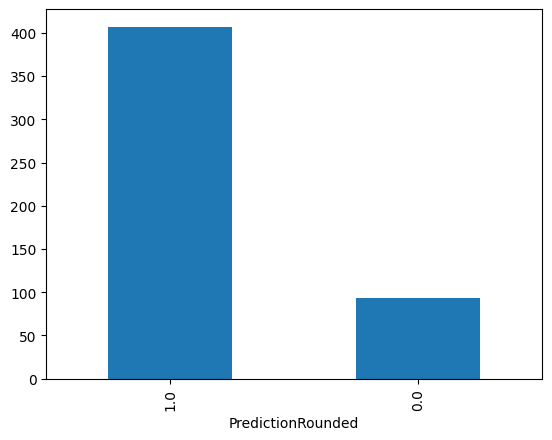

In [127]:
plot_3 = bug_df['PredictionRounded'].value_counts().plot(kind='bar')

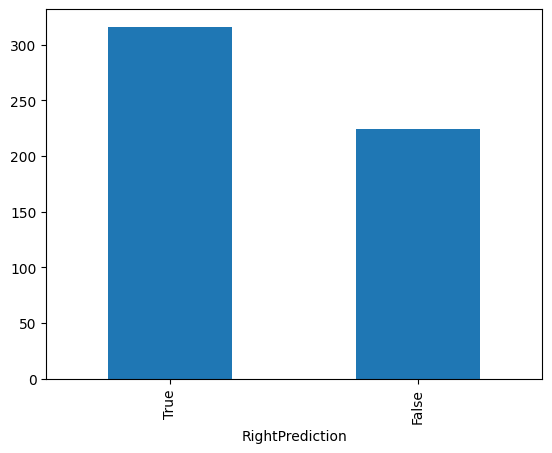

In [128]:

plot_4 = holdout_bug_df['RightPrediction'].value_counts().plot(kind='bar')

In [35]:
holdout_true_bugs_df = holdout_bug_df.loc[(holdout_bug_df['RightPrediction'] == True) & (holdout_bug_df['TP'] == 1)]

In [58]:
holdout_true_bugs_dfs = []
for method in holdout_methods:
    temp = holdout_true_bugs_df.loc[holdout_true_bugs_df['FailingMethod'] == method]
    holdout_true_bugs_dfs.append(temp)

In [ ]:
for dataf in holdout_true_bugs_dfs:
    # print(dataf['FailingMethod'].iloc[0])
    dataf.to_csv('./'+dataf['FailingMethod'].iloc[0]+'.csv', columns=['Answer.explanation'])

In [ ]:
# ChatGPT Prompt: 

# Hello :)
# Please generate out of the explanations from the csv file a single explanation by merging the given explanations in a way that minimizes redundant information, while keeping the information that would be necessary for someone else to fix the bug.

In [133]:
HIT01_8_exp = 'Minutes are set to -15, which is less than 0, causing an illegal argument exception. The code checks that 0 <= minutes < 60, but minutesOffset is -15, which falls outside this range, triggering an exception. The logical check ensures minuteOffset is not less than 0 or greater than 59, but since the value is out of bounds (negative), it causes the error. The issue is identified on line 279.'

In [80]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [81]:
reference_temp = holdout_true_bugs_dfs[0]['Answer.explanation'].to_list()
reference = []
for sen in reference_temp:
    reference.append(sen.split())
sentence = HIT01_8_exp.split()

In [116]:
print('BLEU score -> {}'.format(sentence_bleu(reference, sentence, smoothing_function=SmoothingFunction().method0)))

BLEU score -> 6.867526856655566e-155


/Users/christiancarljacob/Library/CloudStorage/OneDrive-Persönlich/Chrissi/HPI/Master/WiSe2425/ASE/Repo/ASE-GenAI/.conda/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/christiancarljacob/Library/CloudStorage/OneDrive-Persönlich/Chrissi/HPI/Master/WiSe2425/ASE/Repo/ASE-GenAI/.conda/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [132]:
print('BLEU score -> {}'.format(sentence_bleu(reference, sentence, smoothing_function=SmoothingFunction().method1)))

BLEU score -> 0.01772075502789348


In [111]:
from rouge_metric import PyRouge

rouge_references_2 = [holdout_true_bugs_dfs[0]['Answer.explanation'].to_list()]
rouge_sentence_2 = [HIT01_8_exp]

rouge = PyRouge(rouge_n=(1, 2, 4), rouge_l=True, skip_gap=4)
scores = rouge.evaluate(rouge_sentence_2, rouge_references_2)
print(scores)

{'rouge-1': {'r': 0.27647058823529413, 'p': 0.10329670329670329, 'f': 0.1504}, 'rouge-2': {'r': 0.024464831804281346, 'p': 0.008918617614269788, 'f': 0.013071895424836602}, 'rouge-4': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.1676470588235294, 'p': 0.06263736263736264, 'f': 0.09119999999999999}}
